In [1]:
# No olvidar que en "google colab" hay que instalar qiskit

########################
# Instala versión 0.45.2
########################
# Importante, poner qiskit-aer en la misma linea de "pip install" para que coja la versión adecuada
try:
    import google.colab
    print("In colab, let's install things...")
    #
    !pip install qiskit[visualization]==0.45.2 qiskit-aer qiskit-ibm-runtime
except ImportError:
    print("NOT in colab")

NOT in colab


<a id='sec_Notebooks_Circ_1_qubit'></a>
# Medidas en circuitos multiqubit
$\newcommand{\ket}[1]{|#1\rangle}$

In [2]:
from IPython.display import display, Latex, Markdown
from matplotlib import pyplot as plt
import scipy.linalg as la
import numpy as np

In [3]:
from qiskit.quantum_info import Statevector
from qiskit.circuit import QuantumRegister, ClassicalRegister,QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.quantum_info import Statevector, schmidt_decomposition
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_state_qsphere, array_to_latex  

In [4]:
simulador = AerSimulator(method = 'statevector')

In [5]:
# Utilería acumulada

# Definimos una función para visualizar el estado y la esfera a la vez
# Permite escalar la(s) esferas(s) con 'inches' pulgadas, si este parámetro
# no se pone, se dibuja al tamaño por defecto
# Si se pone 0, no se dibuja la esfera
def my_display_state_vector(psi, inches=None, prefix=r"|\psi\rangle = "):
    if isinstance(psi, Statevector):
        d_latex = psi.draw('latex', prefix=prefix)
        display(d_latex)
        #
        d_bloch = psi.draw('bloch')
        if isinstance(inches, (int,float)):
            if inches > 0:
                d_bloch.set_size_inches(inches, inches, forward=True)
                display(d_bloch)
        else:
            display(d_bloch)

#----------------------------------------------------------

# Función para simular un circuito con el método "statevector"
# Devuelve el resultado de la simulación
def my_circuit_simulate_statevector(qcirc, shots=1):
    # Instancia del simulador
    sim = AerSimulator(method = "statevector")
     
    # Hacemos una simulación y obtenemos los resultados
    qobj = transpile(qcirc, backend=sim)
    result = sim.run(qobj, shots=shots).result()
    
    return result
    
# Función para simular un circuito con el método "unitary"
# Devuelve el resultado de la simulación
def my_circuit_simulate_unitary(qcirc, shots=1):
    # Instancia del simulador
    sim = AerSimulator(method = "unitary")
     
    # Hacemos una simulación y obtenemos los resultados
    qobj = transpile(qcirc, backend=sim)
    result = sim.run(qobj, shots=shots).result()
    
    return result
    
#----------------------------------------------------------

# Función para obtener el vector de estado final de un cirucito dado
# usando la simulación de vector de estado.
# Devuelve esta tupla de 3 elementos:
#         (estado final, cuenta, resultado)
def my_get_circuit_state(qcirc_in, shots=1, final_probe=True):
    # Hacemos una copia ya que vamos a cambiar el objeto circuito
    qcirc = qcirc_in.copy()
    
    # Ponemos el "probe" para el vector de estado al final
    # del cirucito dado
    # ojo! el circuito no debe de tener un "save_statevector" ya!
    if final_probe:
        qcirc.save_statevector()
    
    # Hacemos una simulación y obtenemos los resultados
    result = my_circuit_simulate_statevector(qcirc, shots)
    state = None
    if final_probe:
        state = result.get_statevector()
    counts = result.get_counts()
    
    return state, counts, result

# Función para obtener la matriz unitaria final de un cirucito dado
# usando la simulación de matriz unitaria.
# Devuelve esta tupla de 2 elementos:
#         (unitary, resultado)
def my_get_circuit_unitary(qcirc_in, shots=1, final_probe=True):
    # Hacemos una copia ya que vamos a cambiar el objeto circuito
    qcirc = qcirc_in.copy()
    
    # Ponemos el "probe" para el vector de estado al final
    # del cirucito dado
    # ojo! el circuito no debe de tener un "save_statevector" ya!
    if final_probe:
        qcirc.save_unitary()
    
    # Hacemos una simulación y obtenemos los resultados
    result = my_circuit_simulate_unitary(qcirc, shots)
    unitary = result.get_unitary()
    
    return unitary, result


<a id='sec_Notebooks_Medidas_II_1'></a>
## Medidas de Pauli


In [6]:
def add_Pauli_measurement(circuit,paulistring):
    
    assert(circuit.num_qubits==len(paulistring))
    
    len_string = len(paulistring)
    
    for i in range(len(paulistring)):
    #for i,basis in enumerate(paulistring)):
        if  paulistring[len_string -1 - i] == 'X':
            circuit.h(i)    
            circuit.measure(i, i)
        elif paulistring[len(paulistring) -1 - i] == 'Z':
            circuit.measure(i, i)
            pass    
        elif paulistring[len(paulistring) -1 - i] == 'Y':
            circuit.sdg(i)
            circuit.h(i)
            circuit.measure(i, i)
    return circuit



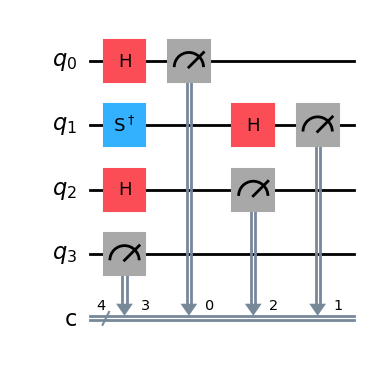

In [7]:
circuit_Pauli = QuantumCircuit(4,4)
add_Pauli_measurement(circuit_Pauli,'ZXYX')  # probar a cambiar el aparato de medida
circuit_Pauli.draw('mpl',style="iqp")

<a id='sec_Notebooks_Medidas_II_2'></a>
## Medidas de Bell


In [8]:
def add_Bell_measurement(circuit):  
    circuit.cx(0,1)
    circuit.h(0)
    circuit.measure_all()
    
# definimos la base de Bell
B00 = np.array([1,0,0,1]/np.sqrt(2))
B01 = np.array([1,0,0,-1]/np.sqrt(2))
B10 = np.array([0,1,1,0]/np.sqrt(2))
B11 = np.array([0,1,-1,0]/np.sqrt(2))

In [9]:
# Definimos el registro
quantum_reg = QuantumRegister(2, 'q')

# creamos el circuito
circuit_bell         = QuantumCircuit(quantum_reg)
circuit_bell_measure = QuantumCircuit(quantum_reg)

##########################################
# Inicialización: Jugar a comentar y descomentar por pares

#circuit_bell.initialize(B00, quantum_reg)
#circuit_bell_measure.initialize(B00, quantum_reg)

#circuit_bell.initialize(B01, quantum_reg)
#circuit_bell_measure.initialize(B01, quantum_reg)

circuit_bell.initialize(B10, quantum_reg)
circuit_bell_measure.initialize(B10, quantum_reg)

#circuit_bell.initialize(B11, quantum_reg)
#circuit_bell_measure.initialize(B11, quantum_reg)

###########################################

# añadimos el medidor en la base de Bell
circuit_bell.measure_all()
add_Bell_measurement(circuit_bell_measure)

'Bell circuit'

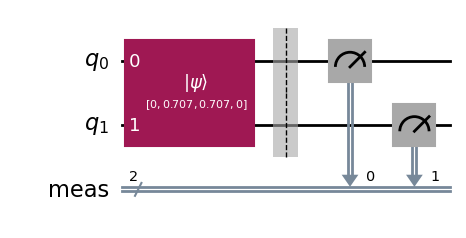

'Bell measurement circuit'

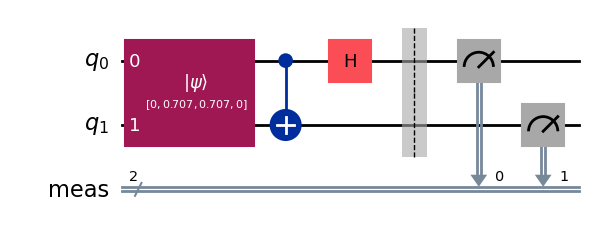

In [10]:
display("Bell circuit", circuit_bell.draw('mpl', style="iqp"))
display("Bell measurement circuit", circuit_bell_measure.draw('mpl', style="iqp"))

In [11]:
# Medimos en el circuito con los medidores estándar
s, c, r = my_get_circuit_state(circuit_bell, shots=1000)

counts_bell = c
display(counts_bell)

{'01': 515, '10': 485}

In [12]:
# Medimos en el circuito con el medidor de Bell
s, c, r = my_get_circuit_state(circuit_bell_measure, shots=1000)

counts_bell_measure = c
display(counts_bell_measure)

{'10': 1000}

<a id='sec_Notebooks_Medidas_II_3'></a>
## Valor esperado de una cadena de Pauli

Veamos cómo calcular el valor esperado del operador

$$
\langle Z\otimes Z\otimes Z\rangle_\Psi  = \langle \Psi |   Z\otimes Z\otimes Z |\Psi \rangle
$$

en el siguiente estado

$$
|\psi> = \frac{i}{4}|000>+\frac{1}{\sqrt{8}}|001>+\frac{1+i}{4}|010>+\frac{1+2i}{\sqrt{8}}|101>+\frac{1}{4}|110>
$$

Primero lo inicializamos

In [13]:
input_vector = [1/4*1J,1/np.sqrt(8)*(1+0J),1/4*(1+1J),0,0,1/np.sqrt(8)*(1+2J),1/4,0]

# normalizaremos a la unidad por si acaso no está normalizado
input_vector /= np.linalg.norm(input_vector)
print('norma=',np.linalg.norm(input_vector))

Statevector(input_vector).draw('latex')

norma= 1.0000000000000002


<IPython.core.display.Latex object>

$ \newcommand{\bra}[1]{\langle #1|} $
$ \newcommand{\ket}[1]{|#1\rangle} $
$ \newcommand{\braket}[2]{\langle #1|#2\rangle} $
$ \newcommand{\i}{{\color{blue} i}} $ 
$ \newcommand{\Hil}{{\mathbb H}} $
$ \newcommand{\boldn}{{\bf n}} $
$ \newcommand{\tr}{{\rm tr}}$

Dado que $Z\ket{a} = (-1)^a\ket{a}$ donde $a=0,1$, entonces tendremos que, sobre un estado $\ket{abc}$ de la base computacional

$$
Z\otimes Z\otimes Z \ket{abc} = Z\ket{a}\otimes Z\ket{b}\otimes Z\ket{c} = (-1)^{a+b+c}\ket{abc}
$$

por lo que el valor esperado  de este operador es
\begin{eqnarray}
\langle Z\otimes Z\otimes Z\rangle_\Psi &=&
\sum_{a,b,c=0,1} (-1)^{a+b+c} P(a,b,c) \nonumber\\ \rule{0mm}{10mm}
&=& \sum_{a,b,c=0,1}(-1)^{a+b+c}\big|\bra{abc}\Psi\rangle\big|^2 
\end{eqnarray}

El circuito que calcula las probabilidades necesarias es el siguiente

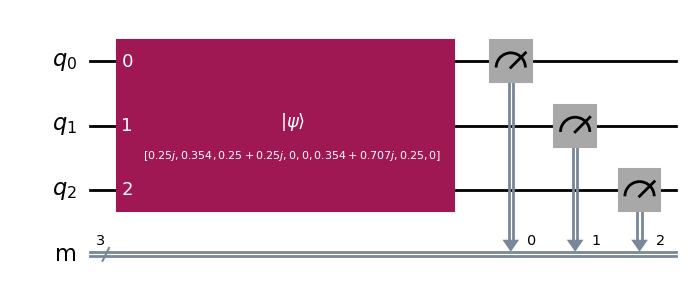

In [14]:
qr = QuantumRegister(3, 'q')
cr = ClassicalRegister(3, 'm')
qc_Pauli = QuantumCircuit(qr,cr)

# inicializar el circuito al vector anterior
qc_Pauli.initialize(input_vector, qr)

# añadimos los medidores estándar (Z)
qc_Pauli.measure(qr,cr)

qc_Pauli.draw(output='mpl', style="iqp")

In [15]:
# simulamos el circuito
s, c, r = my_get_circuit_state(qc_Pauli, shots=10000)
counts_qc_Pauli = c
display(counts_qc_Pauli)

{'001': 1249, '110': 614, '101': 6331, '010': 1176, '000': 630}

In [16]:
# Vamos a definir unas funciones de apoyo para
# calcular la media y la desviación estándard (sigma)

# Este es el valor de la variable aleatoria
# a partir de una cadena binaria (si hay un número
# par de unos devuelve 1, si no -1):
#     '010' -> (-1)^0 * (-1)^1 * (-1)^0
def val(bitstring):
    i = int(bitstring,2)
    v = 1
    while i:
        v *= (-1)**(i & 1)
        i = i>>1
    return v

# Toma un histograma en formato diccionario tal como
# lo devuelve get_counts() y lo transforma en otro diccionario
# con las frecuencias relativas (distribución
# de probabilidad)
def count2prob(counts, nd=3):
    N = 0
    for i in counts.items():
        N += i[1]
    prob = {}
    for i in counts.items():
        prob[i[0]] = np.round(i[1]/N, nd)
    return prob   

# Devuelve la media y la desviación estándar a partir de la cuenta
# en un par:
#    (media, sigma)
def count2avg(counts, nd=3):
    prob = count2prob(counts, nd*2)
    avg = 0  # media
    avg2 = 0 # media de los cuadrados
    for bits,p in prob.items():
        avg  += p * val(bits)
        avg2 += p * val(bits)**2
    var = avg2 - avg**2 # expresión de la varianza
    sigma = np.sqrt(var)
    return np.round(avg,nd), np.round(sigma,nd)



In [17]:
expected, sigma = count2avg(counts_qc_Pauli, 3)
print(f"<ZZZ>={expected} sigma={sigma}")

<ZZZ>=0.515 sigma=0.857


<div style="background-color:#c8e6c9">  
<hr>    
<b>Ejercicio</b>:
<br>        
Calcula el valor esperado de $\langle X\otimes Y\otimes Z\rangle_\Psi$  
<hr>
</div>

<div style="background-color:#c8e6c9"> 
<hr>    
<b>Ejercicio</b>:
<br>        
    
Considera el hamiltoniano $H=A(X\otimes X + Y \otimes Y + Z \otimes Z)$ siendo $A$ una constante real medida en eV.

Calcular el valor esperado de la energía $E = \langle H\rangle_\Psi$  en los cuatro estados de Bell
$\ket{\Psi} = \ket{B_{ij}}$. 
<hr>
</div>

<a id='sec_Notebooks_Medidas_II_4'></a>
## Test de Hadamard

<a id='sec_Notebooks_Medidas_II_4.1'></a>
### Valor esperado de un operador a partir de $\langle X \rangle$ y $\langle Y \rangle$

En este ejemplo
vamos a ver la aplicación del conocido como _test de Hadamard_,
que permite calcular el valor esperado de un operador unitario.

Tomaremos el ejemplo del operador $U=Z\otimes Z \otimes Z$.

In [18]:
qr = QuantumRegister(3, name = 'qr')
qra = QuantumRegister(1, name = 'ancilla')
cr = ClassicalRegister(1)

Creamos un operador controlado a partir de un circuito con el método `to_gate().control()`

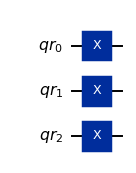

In [19]:
circuit_U = QuantumCircuit(qr)
circuit_U.x(qr)
#circuit_U.x([1])
#circuit_U.x([0,2])

U_c_gate = circuit_U.to_gate(label='CXXX').control(1,ctrl_state= 1)
circuit_U.draw('mpl', scale=0.7, style="iqp")

Creamos el circuito con el operador controlado

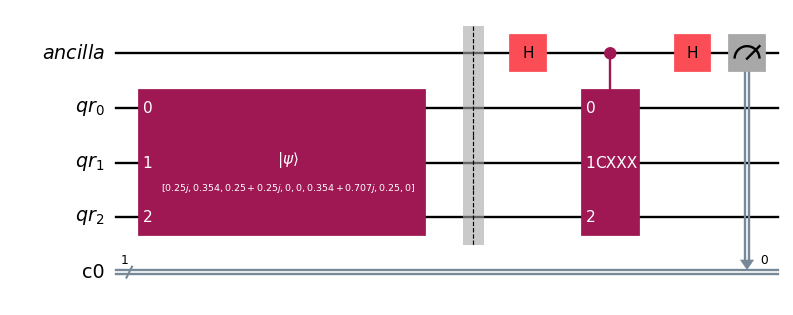

{'1': 4416, '0': 25584}
<Xancilla>=0.7056 sigma=0.7086104


In [20]:
input_vector = [1/4*1J, 1/np.sqrt(8)*(1+0J), 1/4*(1+1J), 0, 0, 1/np.sqrt(8)*(1+2J), 1/4,0]
#input_vector = [1, -3j+2, -17j, 150,     -49, -13, -13+1j, 0]
input_vector /= np.linalg.norm(input_vector)

circuit_Had = QuantumCircuit(qra, qr, cr)
circuit_Had.initialize(input_vector,qr)
#
circuit_Had.barrier()
#
circuit_Had.h(qra)  
circuit_Had.append(U_c_gate, qra[:] + qr[:])
circuit_Had.h(qra)

circuit_Had.measure(qra,cr)
display(circuit_Had.draw('mpl', scale=0.85, style="iqp"))

# Simulemos y calculemos el valor medio
s, c, r = my_get_circuit_state(circuit_Had, shots=30000)
counts_circuit_Had = c
print(counts_circuit_Had)
expected, sigma = count2avg(counts_circuit_Had, nd=7)
print(f"<Xancilla>={expected} sigma={sigma}")

<div style="background-color:#c8e6c9"> 
<hr>    
<b>Ejercicio</b>:
<br>        

Comprobar numéricamente que el valor esperado obtenido en el test de Hadamard es precisamente

$$\text{Re}(\langle\Psi|U|\Psi\rangle)$$

Sugerencia:
- se puede convertir el cicuito con la puerta U **no** controlada en operador:
  
  ```U_gate = circuit_U.to_gate(label='XXX')```
- y se puede obtener la matriz asociada de dicho operador así:

  ```Umat = Operator(U_gate).data```

A partir de ahí es solo operar.
<hr>
</div>

In [21]:
import qiskit
from qiskit_aer import AerSimulator
import qiskit.tools.jupyter
%qiskit_version_table